In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/predict-loan-amount-data


In [42]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv(os.path.join(path, "train.csv"))


print("df shape:", df.shape)
print(df.head())

print(df.info())
print(df.describe())

df.columns


df shape: (30000, 24)
  Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   ...  Credit Score No. of Defaul

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [43]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')



# ---  Drop irrelevant columns ---
drop_cols = ['Customer ID', 'Name', 'Property ID', 'Expense Type 1', 'Expense Type 2',
             'Co-Applicant', 'Gender', 'Profession', 'Type of Employment',
             'No. of Defaults', 'Location', 'Dependents']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# ---  Handle Missing Values ---
df.replace('?', np.nan, inplace=True)

# Convert numerics
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].mean(), inplace=True)

# Convert categorical
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)




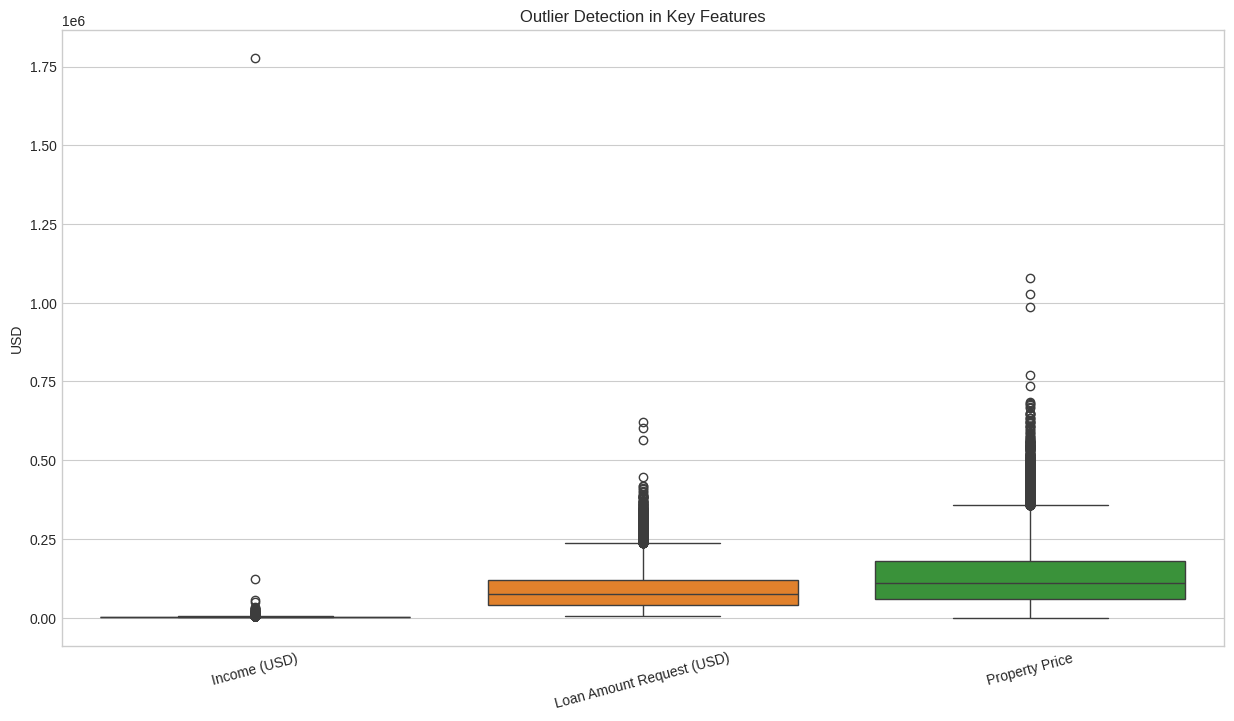

In [44]:
#  Boxplots to identify outliers in key numerical features
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['Income (USD)', 'Loan Amount Request (USD)', 'Property Price']])
plt.title('Outlier Detection in Key Features')
plt.ylabel('USD')
plt.xticks(rotation=15)
plt.show()

In [45]:
# Define columns with potential outliers
outlier_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Property Price', 'Property Age',
       'Current Loan Expenses (USD)', 'Credit Score','Loan Sanction Amount (USD)']

print("Starting outlier treatment...")
# Clip outliers at the 1st and 99th percentiles
for col in outlier_cols:
    if col in df.columns:
        # Calculate quantiles from the training data
        q_low = df[col].quantile(0.01)
        q_hi = df[col].quantile(0.99)

        # Clip the training data
        df[col] = df[col].clip(lower=q_low, upper=q_hi)

print("Outlier treatment complete.")

Starting outlier treatment...
Outlier treatment complete.


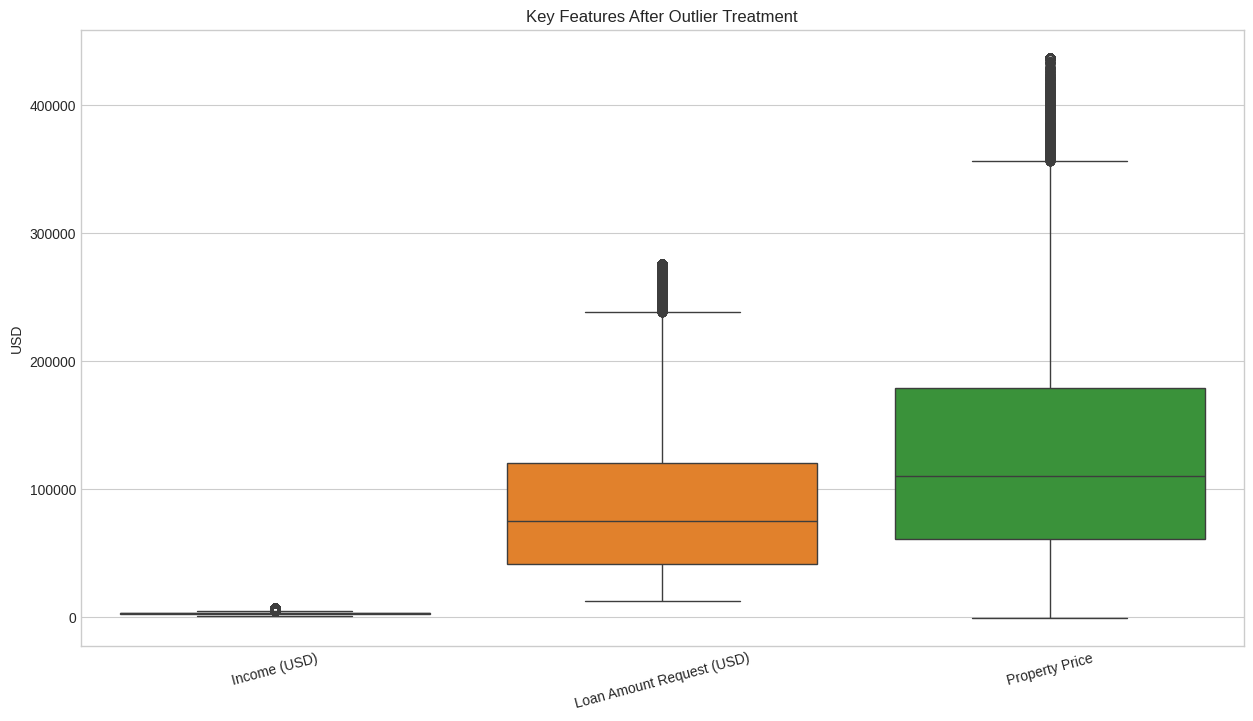

In [56]:
# Visualize boxplots again after treatment to confirm
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['Income (USD)', 'Loan Amount Request (USD)', 'Property Price']])
plt.title('Key Features After Outlier Treatment')
plt.ylabel('USD')
plt.xticks(rotation=15)
plt.show()

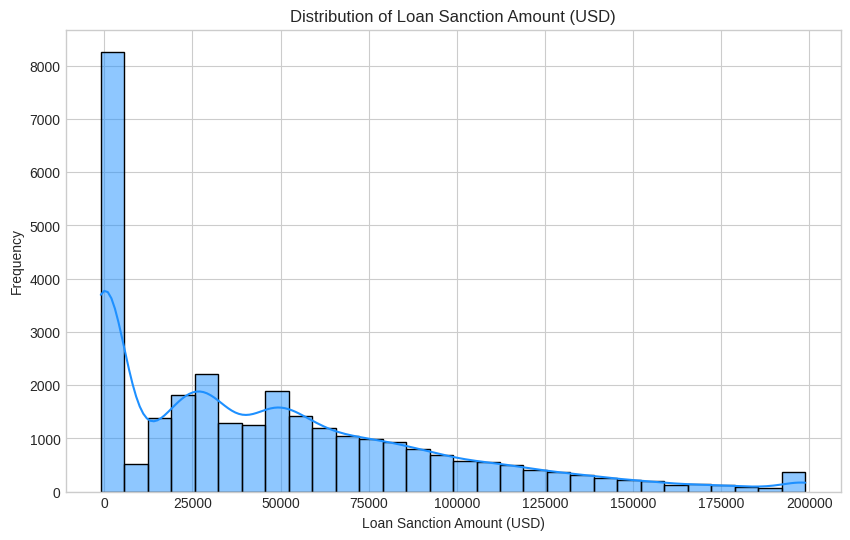

In [57]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Distribution Plot for the target variable: Loan Sanction Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Loan Sanction Amount (USD)'], kde=True, bins=30, color='dodgerblue')
plt.title('Distribution of Loan Sanction Amount (USD)')
plt.xlabel('Loan Sanction Amount (USD)')
plt.ylabel('Frequency')
plt.show()

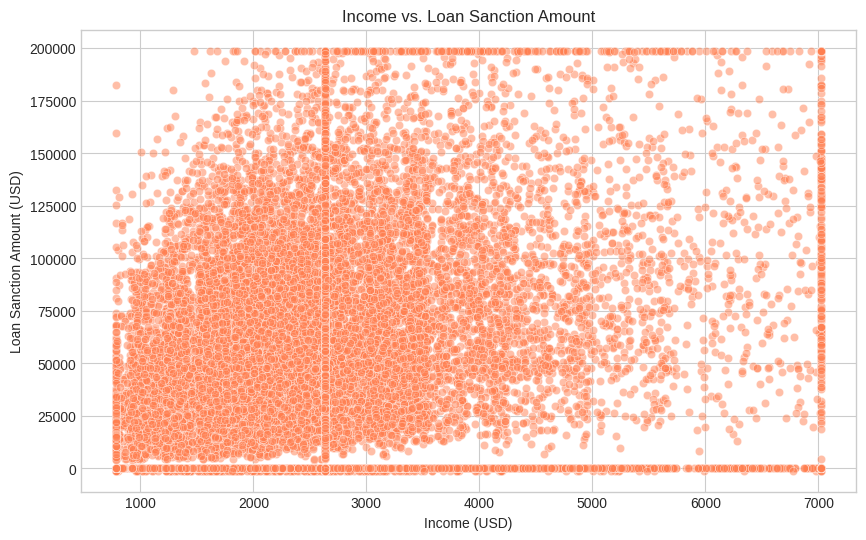

In [58]:
# 2. Scatter Plot: Income vs. Loan Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income (USD)', y='Loan Sanction Amount (USD)', data=df, alpha=0.5, color='coral')
plt.title('Income vs. Loan Sanction Amount')
plt.xlabel('Income (USD)')
plt.ylabel('Loan Sanction Amount (USD)')
plt.show()


In [59]:
# ---  One-Hot Encode Categorical Columns ---
df_encoded = pd.get_dummies(df, drop_first=True)

# ---  Outlier Clipping (1% - 99%) ---
target = 'Loan Sanction Amount (USD)'
outlier_cols = [col for col in df_encoded.columns if df_encoded[col].dtype != 'uint8' and col != target and df_encoded[col].dtype != 'bool']

for col in outlier_cols:
    q_low = df_encoded[col].quantile(0.01)
    q_hi = df_encoded[col].quantile(0.99)
    df_encoded[col] = df_encoded[col].clip(lower=q_low, upper=q_hi)

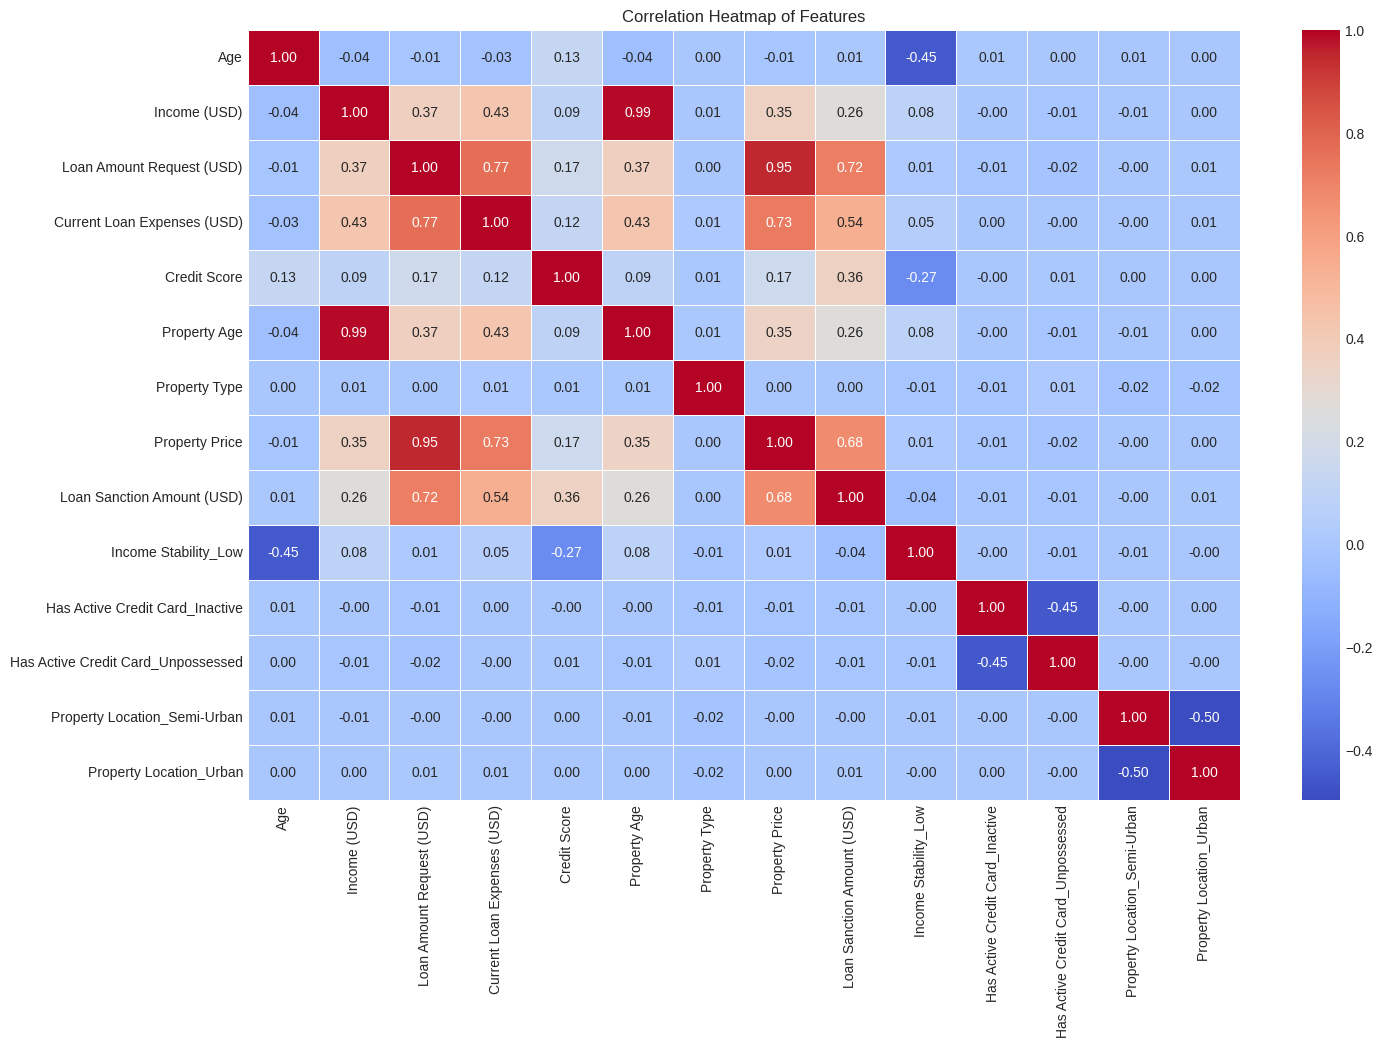

In [61]:
# 3. Correlation Heatmap
plt.figure(figsize=(16, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [51]:
# ---  Split Into X and y ---
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Split into train/val/test (e.g., 60/20/20 split)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ---  Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(" Preprocessing complete.")
print("X_train shape:", X_train_scaled.shape)
print("X_val shape:", X_val_scaled.shape)
print("X_test shape:", X_test_scaled.shape)

 Preprocessing complete.
X_train shape: (18000, 13)
X_val shape: (6000, 13)
X_test shape: (6000, 13)


In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Model Training
model = LinearRegression()
model.fit(X_train_scaled, y_train_full)

# Predict on validation set
val_pred = model.predict(X_val_scaled)

# Evaluation Metrics
mae = mean_absolute_error(y_val, val_pred)
mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_pred)

# Adjusted R²
n = X_val.shape[0]
p = X_val.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("📊 Validation Performance:")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")
print(f"  Adjusted R²: {adjusted_r2:.4f}")


📊 Validation Performance:
  MAE: 21569.98
  MSE: 920052345.27
  RMSE: 30332.36
  R²: 0.5770
  Adjusted R²: 0.5761


In [70]:
from sklearn.model_selection import KFold, cross_val_score
print("\n🔁 Running K-Fold Cross Validation on Training Set...")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_full, cv=cv, scoring='r2')

print("📊 Cross-Validation R² Scores:", np.round(cv_scores, 4))
print(f"✅ Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


🔁 Running K-Fold Cross Validation on Training Set...
📊 Cross-Validation R² Scores: [0.5902 0.5892 0.5141 0.5751 0.5901]
✅ Mean CV R²: 0.5717 ± 0.0294


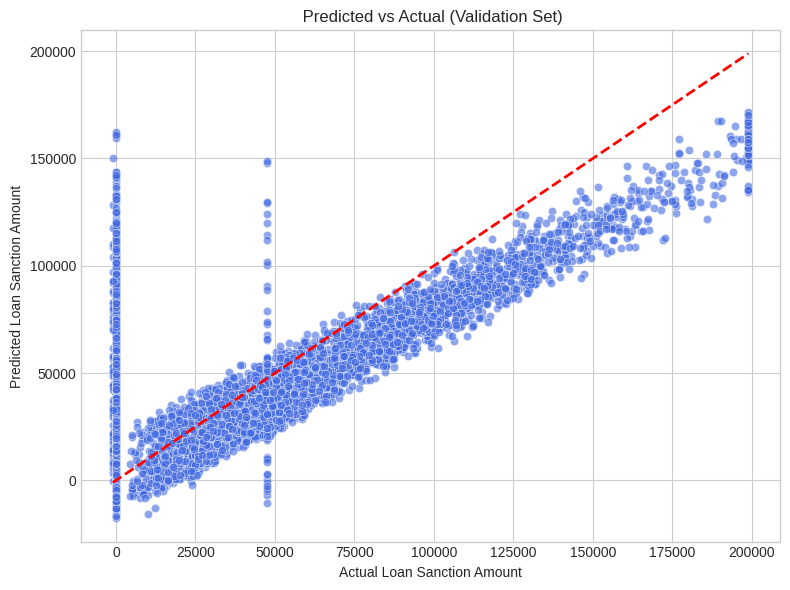

In [73]:
# Plot: Actual vs Predicted on Validation Set ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=val_pred, alpha=0.6, color="royalblue")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='red', linewidth=2)
plt.xlabel("Actual Loan Sanction Amount")
plt.ylabel("Predicted Loan Sanction Amount")
plt.title(" Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
test_pred = model.predict(X_test_scaled)
test_r2 = r2_score(y_test, test_pred)
print(f"\n🧪 R² on Test Set: {test_r2:.4f}")


🧪 R² on Test Set: 0.5576


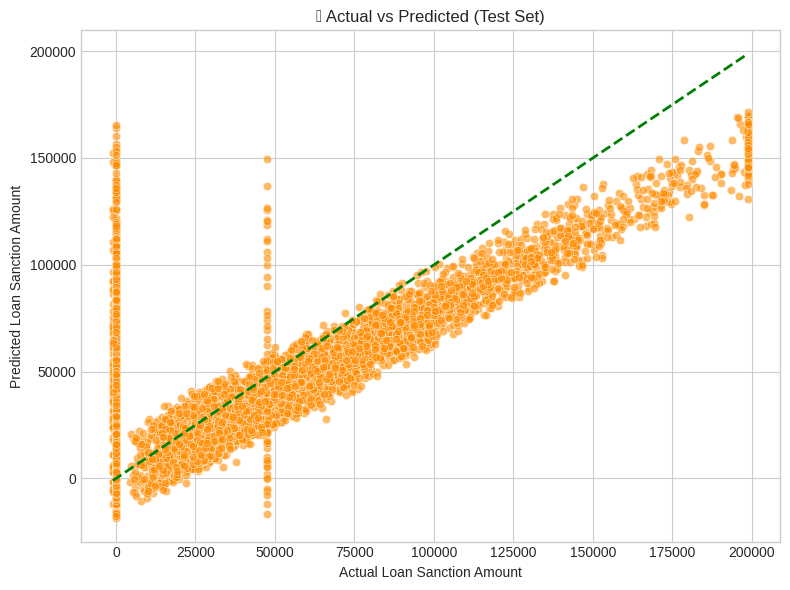

In [75]:
# Plot Actual vs Predicted test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=test_pred, color="darkorange", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='green', linewidth=2)
plt.xlabel("Actual Loan Sanction Amount")
plt.ylabel("Predicted Loan Sanction Amount")
plt.title("📈 Actual vs Predicted (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

Final Review Summary
 1. Data Cleaning
 Dropping irrelevant columns

 Replacing '?' with NaN and imputing correctly (mean for numerics, mode for categoricals)

 2. Outlier Treatment
 Used quantile clipping on both original and encoded numerical features

 Visual confirmation with boxplots pre/post

 3. Encoding
 Used pd.get_dummies() (clean one-hot encoding with drop_first=True)

 4. Train-Validation-Test Split
 60/20/20 split using train_test_split

 Scaling only after the split — perfect order

 5. Modeling
 Using  LinearRegression()

 Evaluating on Validation Set with full metrics

 Added K-Fold Cross Validation for reliability

 Evaluated on Test Set for final performance

 6. Visualization
 Scatter plots for Actual vs Predicted on both validation and test sets

 seaborn plots with proper axis labeling and styling


Output Metrics

Metric	Value

Validation R²	0.5770

Test R²	0.5576

CV Mean R²	Stable